Part 1: Loading Data

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import nltk
import re
import os
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import lda

In [2]:
#we got 100 movie titles and their information (combined from imdb and wikipedia)
#read the movie titles
titles = open('plot_summaries_titles.txt').read().split('\n')
titles = titles[:100] # ensures that only the first 100 are read in

# The wiki information and imdb imforamtion of each movie is separated by the keywords "BREAKS HERE".
# Each information may consist of multiple paragraphs.
info_wiki = open('plot_summaries_wiki.txt').read().split('\n BREAKS HERE')
info_wiki = info_wiki[:100]

info_imdb = open('plot_summaries_imdb.txt').read().split('\n BREAKS HERE')
info_imdb = info_imdb[:100]

# Combine imdb and wiki to get full inforamtion for the movies.
info = []
for i in range(len(info_wiki)):
    item = info_wiki[i] + info_imdb[i]
    info.append(item)

# Because these movies information have already been ranked, we just need
# to generate a list of ordered numbers for future usage.
ranks = range(1, 1+len(titles)) # 1~100

Part 2: Tokenizing and Stemming'
Let's load stopwords and stemmer function from NLTK library. Some examples of stopwords are "a", "the", and "in", which don't convey siginificant meaning. Stemming is the process of breaking a word down into its plain form.

In [3]:
# Use nltk's English stopwords.
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = stopwords.words('english')  #nltk.corpus.

print ("We use" + str(len(stopwords)) + " stopwords from nltk library.")
print ("Examples:", stopwords[:10])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
We use179 stopwords from nltk library.
Examples: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [4]:
nltk.download('punkt')
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

def tokenization_and_stemming(text, stemming=True):
    tokens=[]
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if word not in stopwords:
                tokens.append(word.lower())
                
    # filter out any tokens which does not contain letters (e.g., numeric tokens, raw punctuation)
    
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
            
    if stemming:
        stems = [stemmer.stem(t) for t in filtered_tokens]
        return stems
    else:
        return filtered_tokens

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [5]:
# test
tokenization_and_stemming("Amy looked at her father's arm.")

['ami', 'look', 'father', "'s", 'arm']

In [6]:
# Use our defined functions to analyze (i.e. tokenize, stem) our information
docs_stemmed = []
docs_tokenized = []
for i in info:
    tokenized_and_stemmed_results = tokenization_and_stemming(i)
    docs_stemmed.extend(tokenized_and_stemmed_results)
    tokenized_results = tokenization_and_stemming(i, stemming=False)
    docs_tokenized.extend(tokenized_results)

In [7]:
# Let's create a mapping from stemmed words to original tokenized words for result interpretation
vocab_frame_dict = {docs_stemmed[x]:docs_tokenized[x] for x in range(len(docs_stemmed))}
#test
print (vocab_frame_dict['soldier'])

soldiers


Part 3: TF-IDF
Transform the 100 information to a matrix of TF-IDF features.

In [8]:
# define vectorizer parameters
tfidf_model = TfidfVectorizer(max_df=0.8, min_df=0.2, stop_words='english', 
                              use_idf=True, tokenizer=tokenization_and_stemming, ngram_range=(1,1))

# fit the vectorizer to information
tfidf_matrix = tfidf_model.fit_transform(info)

print ("In total, there are " + str(tfidf_matrix.shape[0]) + \
        " information and " + str(tfidf_matrix.shape[1]) + " terms.")

In total, there are 100 information and 538 terms.


In [9]:
# save the terms identified by TF_IDF
tf_selected_words = tfidf_model.get_feature_names()

Part 4: K-means clustering
Let's use K-means to group the movies

In [10]:
from sklearn.cluster import KMeans

num_clusters = 3   # arbitrary choice
km = KMeans(n_clusters=num_clusters, random_state=0)
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

In [11]:
# Analyse K-means Results
# create DataFrame films from all of the input files.
films = { 'title': titles, 'rank': ranks, 'cluster': clusters}
frame = pd.DataFrame(films, columns = ['rank', 'title', 'cluster'])
frame.head(10)

,rank,title,cluster
0,1,The Godfather,2
1,2,The Shawshank Redemption,2
2,3,Schindler's List,1
3,4,Raging Bull,2
4,5,Casablanca,2
5,6,One Flew Over the Cuckoo's Nest,1
6,7,Gone with the Wind,1
7,8,Citizen Kane,2
8,9,The Wizard of Oz,2
9,10,Titanic,2


In [12]:
print (" Number of movies included in each cluster: ")
frame['cluster'].value_counts().to_frame()

 Number of movies included in each cluster: 


,cluster
2,62
1,28
0,10


In [13]:
grouped = frame[['rank', 'cluster']].groupby('cluster')
print ("Average rank (1 to 100) per cluster: ")
grouped.mean()

Average rank (1 to 100) per cluster: 


,rank
cluster,
0,55.300000
1,42.821429
2,53.193548


In [14]:
print ("<Document clustering result by K-means>")

# km.cluster_centers_ denotes the importances of each items in centroid.
# need to sort it in descending order and get the top k items.
order_centroids = km.cluster_centers_.argsort()[:, ::-1]

Cluster_keywords_summary = {}
for i in range(num_clusters):
    print ("Cluster " + str(i) + " words:") ,
    Cluster_keywords_summary[i] = []
    for ind in order_centroids[i, :10]:  # get the top 6 words of each cluster
        Cluster_keywords_summary[i].append(vocab_frame_dict[tf_selected_words[ind]])
        print (vocab_frame_dict[tf_selected_words[ind]] + ", "),
    print
    
    cluster_movies = frame.loc[frame.cluster == i, 'title'].values.tolist()
    print ("Cluster " + str(i) + " titles (" + str(len(cluster_movies)) + " movies): ")
    print (", ".join(cluster_movies), '\n')


<Document clustering result by K-means>
Cluster 0 words:
george, 
family, 
singing, 
performed, 
captain, 
marries, 
filmed, 
war, 
ii, 
dance, 
Cluster 0 titles (10 movies): 
The Sound of Music, Singin' in the Rain, It's a Wonderful Life, The Philadelphia Story, An American in Paris, The King's Speech, A Place in the Sun, Giant, Nashville, Yankee Doodle Dandy 

Cluster 1 words:
army, 
soldiers, 
killing, 
war, 
commanded, 
orders, 
men, 
general, 
battle, 
forcing, 
Cluster 1 titles (28 movies): 
Schindler's List, One Flew Over the Cuckoo's Nest, Gone with the Wind, Lawrence of Arabia, Star Wars, 2001: A Space Odyssey, The Bridge on the River Kwai, Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb, Apocalypse Now, The Lord of the Rings: The Return of the King, Gladiator, From Here to Eternity, Saving Private Ryan, Raiders of the Lost Ark, Ben-Hur, Patton, Jaws, Braveheart, The Good, the Bad and the Ugly, Butch Cassidy and the Sundance Kid, Platoon, Dances with Wolve

In [15]:
# we can see from the above results to find the main topics of the three cluster of movies are:
# Families, love and life
# Wars and battles
# Detective and crime


# Plot K-means Result
# use PCA to select 2 principal components for visualization
pca = PCA(n_components=2)
tfidf_matrix_np=tfidf_matrix.toarray()
X = pca.fit_transform(tfidf_matrix_np)
xs, ys = X[:, 0], X[:, 1]

# Set up colors per clusters using a dictionary
cluster_colors = {0: 'k', 1: 'b', 2: 'r'}
# set up cluster names using a dictionary
cluster_names = {}
for i in range(num_clusters):
    cluster_names[i] = ", ".join(Cluster_keywords_summary[i])

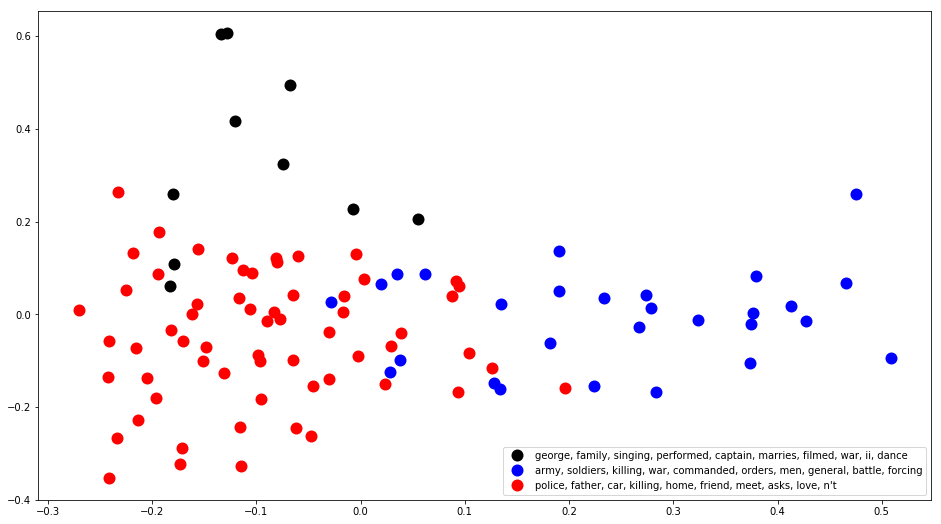

In [16]:
%matplotlib inline

# create data frame with PCA cluster results
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles))
# groups = df.groupby(clusters)
groups = df.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(16, 9))
#Set color for each cluster/group
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
           label=cluster_names[name], color=cluster_colors[name],
           mec='none')

#show legend with only 1 point
ax.legend(numpoints=1, loc='lower right')
plt.show()

Part 5: Topic Modeling - Latent Dirichlet Allocation
Use LDA to group the movies

In [17]:
# Now use inforamtion to build a 100*538 matrix
terms_dict = {tf_selected_words[x]:x for x in range(len(tf_selected_words))}

feature_matrix_info_tf = []
for i in info:
    current_doc_stats = [0] * len(tf_selected_words)
    allwords_stemmed = tokenization_and_stemming(i)
    for get_terms in allwords_stemmed:
        if get_terms in tf_selected_words:
            current_doc_stats[terms_dict[get_terms]] += 1
    current_doc_stats = np.asarray(current_doc_stats)
    feature_matrix_info_tf.append(current_doc_stats)
    
feature_matrix_info_tf = np.asarray(feature_matrix_info_tf)

In [18]:
model = lda.LDA(n_topics=3, n_iter=500, random_state=0)

In [19]:
#@"model.topic_word_"saves the importance of tf_selected_words in LDA model, i.e. words similarity matrix.
# Its shape is (n_toipcs, num_of_selected_words)
#@"model.doc_topic_"saves the document topic results, i.e. document topic matrix. 
# Its shape is (num_of_documents, n_topics)

model.fit(feature_matrix_info_tf)
topic_word = model.topic_word_   # model.components_ also works
n_top_words = 10

topic_keywords_list = []
for topic_dist in topic_word:
    # Here we select the top 6 (n_top_words) words
    lda_topic_words = np.array(tf_selected_words)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    for i in range(len(lda_topic_words)):
        lda_topic_words[i] = vocab_frame_dict[lda_topic_words[i]]
    topic_keywords_list.append(lda_topic_words.tolist())

INFO:lda:n_documents: 100
INFO:lda:vocab_size: 538
INFO:lda:n_words: 61218
INFO:lda:n_topics: 3
INFO:lda:n_iter: 500
INFO:lda:<0> log likelihood: -447812
INFO:lda:<10> log likelihood: -413122
INFO:lda:<20> log likelihood: -402783
INFO:lda:<30> log likelihood: -398617
INFO:lda:<40> log likelihood: -396470
INFO:lda:<50> log likelihood: -395118
INFO:lda:<60> log likelihood: -393928
INFO:lda:<70> log likelihood: -393062
INFO:lda:<80> log likelihood: -392650
INFO:lda:<90> log likelihood: -391784
INFO:lda:<100> log likelihood: -390917
INFO:lda:<110> log likelihood: -390273
INFO:lda:<120> log likelihood: -390534
INFO:lda:<130> log likelihood: -390092
INFO:lda:<140> log likelihood: -390318
INFO:lda:<150> log likelihood: -389616
INFO:lda:<160> log likelihood: -389337
INFO:lda:<170> log likelihood: -388750
INFO:lda:<180> log likelihood: -388836
INFO:lda:<190> log likelihood: -388691
INFO:lda:<200> log likelihood: -387748
INFO:lda:<210> log likelihood: -387632
INFO:lda:<220> log likelihood: -3876

In [20]:
doc_topic = model.doc_topic_
topic_doc_dict = {}

print ("<Document clustering result by LDA>")
for i in range(len(doc_topic)):
    topicID = doc_topic[i].argmax()
    if topicID not in topic_doc_dict:
        topic_doc_dict[topicID] = [titles[i]]
    else:
        topic_doc_dict[topicID].append(titles[i])
for i in topic_doc_dict:
    print ("Cluster " + str(i) + " words: " + ", ".join(topic_keywords_list[i]))
    print ("Cluster " + str(i) + " titles (" + str(len(topic_doc_dict[i])) + " movies): ")
    print (', '.join(topic_doc_dict[i]), '\n')

<Document clustering result by LDA>
Cluster 1 words: friend, family, father, george, home, love, want, new, life, becomes
Cluster 1 titles (36 movies): 
The Godfather, Raging Bull, Gone with the Wind, Citizen Kane, Titanic, The Godfather: Part II, Forrest Gump, The Sound of Music, It's a Wonderful Life, 12 Angry Men, Amadeus, Gandhi, A Streetcar Named Desire, The Philadelphia Story, The Best Years of Our Lives, Ben-Hur, Doctor Zhivago, Braveheart, High Noon, The Pianist, Goodfellas, The King's Speech, It Happened One Night, A Place in the Sun, Midnight Cowboy, Mr. Smith Goes to Washington, Rain Man, Annie Hall, Out of Africa, Good Will Hunting, Terms of Endearment, Giant, Network, Wuthering Heights, Rebel Without a Cause, Yankee Doodle Dandy 

Cluster 0 words: days, n't, say, night, asks, car, away, killing, goes, police
Cluster 0 titles (48 movies): 
The Shawshank Redemption, Casablanca, One Flew Over the Cuckoo's Nest, The Wizard of Oz, Psycho, Sunset Blvd., Vertigo, On the Waterfron

We got a similar set of three clusters/topics as those we got with KMeans, but the way ther are grouped is different.